## hparams.py

In [1]:
from easydict import EasyDict

def create_hparams(hparams_string=None, verbose=False):
    """Create model hyperparameters. Parse nondefault from given string."""

    hparams = EasyDict(
        ################################
        # Experiment Parameters        #
        ################################
        epochs=500,
        iters_per_checkpoint=1000,
        seed=1234,
        dynamic_loss_scaling=True,
        fp16_run=False,
        distributed_run=False,
        dist_backend="nccl",
        dist_url="tcp://localhost:54321",
        cudnn_enabled=True,
        cudnn_benchmark=False,
        ignore_layers=['embedding.weight', 'latent_encoder'],

        ################################
        # Data Parameters             #
        ################################
        load_mel_from_disk=False,
        training_files='filelists/kss_22050_audio_text_train_filelist.txt',
        validation_files='filelists/kss_audio_text_val_filelist.txt',
        text_cleaners=['english_cleaners'],

        ################################
        # Audio Parameters             #
        ################################
        max_wav_value=32768.0,
        sampling_rate=22050,
        filter_length=1024,
        hop_length=256,
        win_length=1024,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=8000.0,

        ################################
        # Model Parameters             #
        ################################
        n_symbols=256,
        symbols_embedding_dim=512,

        # Encoder parameters
        encoder_kernel_size=5,
        encoder_n_convolutions=3,
        encoder_embedding_dim=512,
        
        # Decoder parameters
        n_frames_per_step=1,  # currently only 1 is supported
        decoder_rnn_dim=1024,
        prenet_dim=256,
        max_decoder_steps=1000,
        gate_threshold=0.5,
        p_attention_dropout=0.1,
        p_decoder_dropout=0.1,

        # Attention parameters
        attention_rnn_dim=1024,
        attention_dim=128,

        # Location Layer parameters
        attention_location_n_filters=32,
        attention_location_kernel_size=31,

        # Mel-post processing network parameters
        postnet_embedding_dim=512,
        postnet_kernel_size=5,
        postnet_n_convolutions=5,

        ################################
        # Optimization Hyperparameters #
        ################################
        use_saved_learning_rate=False,
        learning_rate=1e-3,
        weight_decay=1e-6,
        grad_clip_thresh=1.0,
        batch_size=64,
        mask_padding=True  # set model's padded outputs to padded values
    )

#     if hparams_string:
#         tf.logging.info('Parsing command line hparams: %s', hparams_string)
#         hparams.parse(hparams_string)

#     if verbose:
#         tf.logging.info('Final parsed hparams: %s', hparams.values())

    return hparams


## utils.py

In [2]:
import numpy as np
from scipy.io.wavfile import read
import torch
import librosa

def text_to_utf8(text):
    utf = []
    for u in text.encode('utf-8'):
        utf.append(u)
        
    return np.array(utf).astype(int)

def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool()
    return mask

def load_wav_to_torch(full_path):
    data, sampling_rate = librosa.core.load(full_path, sr=22050, mono=True)
    data /= max(abs(data))
    data = librosa.effects.trim(data, top_db=40, frame_length=1024, hop_length=256)[0]
    return torch.FloatTensor(data.astype(np.float32)), sampling_rate


def load_filepaths_and_text(filename, split="|"):
    with open(filename, encoding='utf-8') as f:
        filepaths_and_text = [line.strip().split(split) for line in f]
    return filepaths_and_text


def to_gpu(x):
    x = x.contiguous()

    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

def make_pad_mask(lengths, xs=None, length_dim=-1):
    """Make mask tensor containing indices of padded part.

    Args:
        lengths (LongTensor or List): Batch of lengths (B,).
        xs (Tensor, optional): The reference tensor. If set, masks will be the same shape as this tensor.
        length_dim (int, optional): Dimension indicator of the above tensor. See the example.

    Returns:
        Tensor: Mask tensor containing indices of padded part.
                dtype=torch.uint8 in PyTorch 1.2-
                dtype=torch.bool in PyTorch 1.2+ (including 1.2)

    Examples:
        With only lengths.

        >>> lengths = [5, 3, 2]
        >>> make_non_pad_mask(lengths)
        masks = [[0, 0, 0, 0 ,0],
                 [0, 0, 0, 1, 1],
                 [0, 0, 1, 1, 1]]

        With the reference tensor.

        >>> xs = torch.zeros((3, 2, 4))
        >>> make_pad_mask(lengths, xs)
        tensor([[[0, 0, 0, 0],
                 [0, 0, 0, 0]],
                [[0, 0, 0, 1],
                 [0, 0, 0, 1]],
                [[0, 0, 1, 1],
                 [0, 0, 1, 1]]], dtype=torch.uint8)
        >>> xs = torch.zeros((3, 2, 6))
        >>> make_pad_mask(lengths, xs)
        tensor([[[0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1]],
                [[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]],
                [[0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1]]], dtype=torch.uint8)

        With the reference tensor and dimension indicator.

        >>> xs = torch.zeros((3, 6, 6))
        >>> make_pad_mask(lengths, xs, 1)
        tensor([[[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1]],
                [[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1]],
                [[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)
        >>> make_pad_mask(lengths, xs, 2)
        tensor([[[0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1]],
                [[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]],
                [[0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1]]], dtype=torch.uint8)

    """
    if length_dim == 0:
        raise ValueError('length_dim cannot be 0: {}'.format(length_dim))

    if not isinstance(lengths, list):
        lengths = lengths.tolist()
    bs = int(len(lengths))
    if xs is None:
        maxlen = int(max(lengths))
    else:
        maxlen = xs.size(length_dim)

    seq_range = torch.arange(0, maxlen, dtype=torch.int64)
    seq_range_expand = seq_range.unsqueeze(0).expand(bs, maxlen)
    seq_length_expand = seq_range_expand.new(lengths).unsqueeze(-1)
    mask = seq_range_expand >= seq_length_expand

    if xs is not None:
        assert xs.size(0) == bs, (xs.size(0), bs)

        if length_dim < 0:
            length_dim = xs.dim() + length_dim
        # ind = (:, None, ..., None, :, , None, ..., None)
        ind = tuple(slice(None) if i in (0, length_dim) else None
                    for i in range(xs.dim()))
        mask = mask[ind].expand_as(xs).to(xs.device)
    return mask


def make_non_pad_mask(lengths, xs=None, length_dim=-1):
    """Make mask tensor containing indices of non-padded part.

    Args:
        lengths (LongTensor or List): Batch of lengths (B,).
        xs (Tensor, optional): The reference tensor. If set, masks will be the same shape as this tensor.
        length_dim (int, optional): Dimension indicator of the above tensor. See the example.

    Returns:
        ByteTensor: mask tensor containing indices of padded part.
                    dtype=torch.uint8 in PyTorch 1.2-
                    dtype=torch.bool in PyTorch 1.2+ (including 1.2)

    Examples:
        With only lengths.

        >>> lengths = [5, 3, 2]
        >>> make_non_pad_mask(lengths)
        masks = [[1, 1, 1, 1 ,1],
                 [1, 1, 1, 0, 0],
                 [1, 1, 0, 0, 0]]

        With the reference tensor.

        >>> xs = torch.zeros((3, 2, 4))
        >>> make_non_pad_mask(lengths, xs)
        tensor([[[1, 1, 1, 1],
                 [1, 1, 1, 1]],
                [[1, 1, 1, 0],
                 [1, 1, 1, 0]],
                [[1, 1, 0, 0],
                 [1, 1, 0, 0]]], dtype=torch.uint8)
        >>> xs = torch.zeros((3, 2, 6))
        >>> make_non_pad_mask(lengths, xs)
        tensor([[[1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0]],
                [[1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]],
                [[1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

        With the reference tensor and dimension indicator.

        >>> xs = torch.zeros((3, 6, 6))
        >>> make_non_pad_mask(lengths, xs, 1)
        tensor([[[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0]],
                [[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0]],
                [[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0]]], dtype=torch.uint8)
        >>> make_non_pad_mask(lengths, xs, 2)
        tensor([[[1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0]],
                [[1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]],
                [[1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

    """
    return ~make_pad_mask(lengths, xs, length_dim)


## layers.py

In [3]:
import torch
from librosa.filters import mel as librosa_mel_fn
from audio_processing import dynamic_range_compression
from audio_processing import dynamic_range_decompression
from stft import STFT

class LinearNorm(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

        torch.nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear_layer(x)


class ConvNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal


class TacotronSTFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024,
                 n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0,
                 mel_fmax=8000.0):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFT(filter_length, hop_length, win_length)
        mel_basis = librosa_mel_fn(
            sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]

        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """
        assert(torch.min(y.data) >= -1)
        assert(torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        return mel_output


## data_utils.py

In [4]:
import random
import numpy as np
import torch
from torch.nn import functional as F
import torch.utils.data
import os

class TextMelLoader(torch.utils.data.Dataset):
    """
        1) loads audio,text pairs
        2) normalizes text and converts them to sequences of one-hot vectors
        3) computes mel-spectrograms from audio files.
    """
    def __init__(self, audiopaths_and_text, hparams):
        self.audiopaths_and_text = load_filepaths_and_text(audiopaths_and_text)
        self.text_cleaners = hparams.text_cleaners
        self.max_wav_value = hparams.max_wav_value
        self.sampling_rate = hparams.sampling_rate
        self.load_mel_from_disk = hparams.load_mel_from_disk
        self.stft = TacotronSTFT(
            hparams.filter_length, hparams.hop_length, hparams.win_length,
            hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
            hparams.mel_fmax)
        random.seed(1234)
        #random.shuffle(self.audiopaths_and_text)
        
    def get_mel_text_pair(self, audiopath_and_text):
        # separate filename and text
        audiopath, text = audiopath_and_text[0], audiopath_and_text[1]
        text = self.get_text(text)
        mel = self.get_mel(audiopath)
        
        return (mel, text, audiopath)

    def get_mel(self, filename):
        if not self.load_mel_from_disk:
            audio, sampling_rate = load_wav_to_torch(filename)
            if sampling_rate != self.stft.sampling_rate:
                raise ValueError("{} {} SR doesn't match target {} SR".format(
                    sampling_rate, self.stft.sampling_rate))
            #audio_norm = audio / self.max_wav_value
            audio_norm = audio
            audio_norm = audio_norm.unsqueeze(0)
            audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
            melspec = self.stft.mel_spectrogram(audio_norm)
            melspec = torch.squeeze(melspec, 0)
        else:
            melspec = torch.from_numpy(np.load(filename))
            assert melspec.size(0) == self.stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), self.stft.n_mel_channels))
        
        melspec = melspec
        
        return melspec

    def get_text(self, text):
        text_norm = torch.IntTensor(text_to_utf8(text))
        #text_norm = torch.IntTensor(text_to_sequence(text, self.text_cleaners))
        return text_norm

    def __getitem__(self, index):
        return self.get_mel_text_pair(self.audiopaths_and_text[index])

    def __len__(self):
        return len(self.audiopaths_and_text)


class TextMelCollate():
    """ Zero-pads model inputs and targets based on number of frames per setep
    """
    def __init__(self, n_frames_per_step):
        self.n_frames_per_step = n_frames_per_step

    def __call__(self, batch):
        """Collate's training batch from normalized text and mel-spectrogram
        PARAMS
        ------
        batch: [mel_normalized, text_normalized, audiopath]
        mel: (80, T)
        text: (N)
        audiopath: str
        """
        
        # Right zero-pad all one-hot text sequences to max input length
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([x[0].shape[1] for x in batch]),
            dim=0, descending=True)
        max_input_len = input_lengths[0]
        
        if max_input_len % self.n_frames_per_step != 0:
            max_input_len += self.n_frames_per_step - max_input_len % self.n_frames_per_step
            assert max_input_len % self.n_frames_per_step == 0

        # include mel padded and gate padded
        num_mels = batch[0][0].size(0)
        mel_padded = torch.FloatTensor(len(batch), num_mels, max_input_len)
        mel_padded.zero_()
        
        audio_paths = []
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]][0]
            mel_padded[i, :, :mel.size(1)] = mel
            audio_paths.append(batch[ids_sorted_decreasing[i]][2])
        
        max_target_len = max([len(x[1]) for x in batch])
        text_padded = torch.LongTensor(len(batch), max_target_len)
        text_padded.zero_()
        output_lengths = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            text = batch[ids_sorted_decreasing[i]][1]
            text_padded[i, :text.size(0)] = text
            output_lengths[i] = text.size(0)

        outputs = {}
        outputs.update({"mel_padded": mel_padded})
        outputs.update({"input_lengths": input_lengths})
        outputs.update({"text_padded": text_padded})
        outputs.update({"output_lengths": output_lengths})
        outputs.update({"audio_paths": audio_paths})
        
        return outputs

In [5]:
from torch.utils.data import DataLoader

hparams = create_hparams()
for param in hparams:
    print(param, ':', hparams[param])
    
def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = None
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=4, shuffle=False,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn

train_loader, valset, collate_fn = prepare_dataloaders(hparams)

epochs : 500
iters_per_checkpoint : 1000
seed : 1234
dynamic_loss_scaling : True
fp16_run : False
distributed_run : False
dist_backend : nccl
dist_url : tcp://localhost:54321
cudnn_enabled : True
cudnn_benchmark : False
ignore_layers : ['embedding.weight', 'latent_encoder']
load_mel_from_disk : False
training_files : filelists/kss_22050_audio_text_train_filelist.txt
validation_files : filelists/kss_audio_text_val_filelist.txt
text_cleaners : ['english_cleaners']
max_wav_value : 32768.0
sampling_rate : 22050
filter_length : 1024
hop_length : 256
win_length : 1024
n_mel_channels : 80
mel_fmin : 0.0
mel_fmax : 8000.0
n_symbols : 256
symbols_embedding_dim : 512
encoder_kernel_size : 5
encoder_n_convolutions : 3
encoder_embedding_dim : 512
n_frames_per_step : 1
decoder_rnn_dim : 1024
prenet_dim : 256
max_decoder_steps : 1000
gate_threshold : 0.5
p_attention_dropout : 0.1
p_decoder_dropout : 0.1
attention_rnn_dim : 1024
attention_dim : 128
attention_location_n_filters : 32
attention_location

## loss_function.py

In [6]:
class GuidedAttentionLoss(torch.nn.Module):
    """Guided attention loss function module.

    This module calculates the guided attention loss described in `Efficiently Trainable Text-to-Speech System Based
    on Deep Convolutional Networks with Guided Attention`_, which forces the attention to be diagonal.

    .. _`Efficiently Trainable Text-to-Speech System Based on Deep Convolutional Networks with Guided Attention`:
        https://arxiv.org/abs/1710.08969

    """

    def __init__(self, sigma=0.4, alpha=1.0, reset_always=True):
        """Initialize guided attention loss module.

        Args:
            sigma (float, optional): Standard deviation to control how close attention to a diagonal.
            alpha (float, optional): Scaling coefficient (lambda).
            reset_always (bool, optional): Whether to always reset masks.

        """
        super(GuidedAttentionLoss, self).__init__()
        self.sigma = sigma
        self.alpha = alpha
        self.reset_always = reset_always
        self.guided_attn_masks = None
        self.masks = None

    def _reset_masks(self):
        self.guided_attn_masks = None
        self.masks = None

    def forward(self, att_ws, ilens, olens):
        """Calculate forward propagation.

        Args:
            att_ws (Tensor): Batch of attention weights (B, T_max_out, T_max_in).
            ilens (LongTensor): Batch of input lenghts (B,).
            olens (LongTensor): Batch of output lenghts (B,).

        Returns:
            Tensor: Guided attention loss value.

        """
        if self.guided_attn_masks is None:
            self.guided_attn_masks = self._make_guided_attention_masks(ilens, olens).to(att_ws.device)
        if self.masks is None:
            self.masks = self._make_masks(ilens, olens).to(att_ws.device)
        losses = self.guided_attn_masks * att_ws
        loss = torch.mean(losses.masked_select(self.masks))
        if self.reset_always:
            self._reset_masks()
        return self.alpha * loss

    def _make_guided_attention_masks(self, ilens, olens):
        n_batches = len(ilens)
        max_ilen = max(ilens)
        max_olen = max(olens)
        guided_attn_masks = torch.zeros((n_batches, max_olen, max_ilen))
        for idx, (ilen, olen) in enumerate(zip(ilens, olens)):
            guided_attn_masks[idx, :olen, :ilen] = self._make_guided_attention_mask(ilen, olen, self.sigma)
        return guided_attn_masks

    @staticmethod
    def _make_guided_attention_mask(ilen, olen, sigma):
        """Make guided attention mask.

        Examples:
            >>> guided_attn_mask =_make_guided_attention(5, 5, 0.4)
            >>> guided_attn_mask.shape
            torch.Size([5, 5])
            >>> guided_attn_mask
            tensor([[0.0000, 0.1175, 0.3935, 0.6753, 0.8647],
                    [0.1175, 0.0000, 0.1175, 0.3935, 0.6753],
                    [0.3935, 0.1175, 0.0000, 0.1175, 0.3935],
                    [0.6753, 0.3935, 0.1175, 0.0000, 0.1175],
                    [0.8647, 0.6753, 0.3935, 0.1175, 0.0000]])
            >>> guided_attn_mask =_make_guided_attention(3, 6, 0.4)
            >>> guided_attn_mask.shape
            torch.Size([6, 3])
            >>> guided_attn_mask
            tensor([[0.0000, 0.2934, 0.7506],
                    [0.0831, 0.0831, 0.5422],
                    [0.2934, 0.0000, 0.2934],
                    [0.5422, 0.0831, 0.0831],
                    [0.7506, 0.2934, 0.0000],
                    [0.8858, 0.5422, 0.0831]])

        """
        grid_x, grid_y = torch.meshgrid(torch.arange(olen), torch.arange(ilen))
        grid_x, grid_y = grid_x.float(), grid_y.float()
        return 1.0 - torch.exp(-(grid_y / ilen - grid_x / olen) ** 2 / (2 * (sigma ** 2)))

    @staticmethod
    def _make_masks(ilens, olens):
        """Make masks indicating non-padded part.

        Args:
            ilens (LongTensor or List): Batch of lengths (B,).
            olens (LongTensor or List): Batch of lengths (B,).

        Returns:
            Tensor: Mask tensor indicating non-padded part.
                    dtype=torch.uint8 in PyTorch 1.2-
                    dtype=torch.bool in PyTorch 1.2+ (including 1.2)

        Examples:
            >>> ilens, olens = [5, 2], [8, 5]
            >>> _make_mask(ilens, olens)
            tensor([[[1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1]],
                    [[1, 1, 0, 0, 0],
                     [1, 1, 0, 0, 0],
                     [1, 1, 0, 0, 0],
                     [1, 1, 0, 0, 0],
                     [1, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0]]], dtype=torch.uint8)

        """
        in_masks = make_non_pad_mask(ilens)  # (B, T_in)
        out_masks = make_non_pad_mask(olens)  # (B, T_out)
        return out_masks.unsqueeze(-1) & in_masks.unsqueeze(-2)  # (B, T_out, T_in)

class Tacotron2Loss(torch.nn.Module):
    def __init__(self):
        super(Tacotron2Loss, self).__init__()
        self.attn_loss = GuidedAttentionLoss(sigma=0.4, alpha=1.0)
            
    def forward(self, batch, outputs):
        
        input_lengths = batch["input_lengths"]
        text_padded = batch["text_padded"]
        output_lengths = batch["output_lengths"]
        
        logits = outputs['logits']
        alignments = outputs['alignments']

        mask = get_mask_from_lengths(output_lengths)
        
        ce_loss = nn.CrossEntropyLoss(reduce=False)(logits.transpose(1, 2), text_padded)
        ce_loss = torch.mean(ce_loss * mask)
        attn_loss = self.attn_loss(alignments, input_lengths, output_lengths)
        total_loss = ce_loss + attn_loss
        
        return total_loss


## model.py

In [7]:
from math import sqrt
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

class GMMAttention(nn.Module):
    def __init__(self):
        super(GMMAttention, self).__init__()
        self.K = K = 1
        last_linear = nn.Linear(128, K * 3, bias=False)
        last_linear.weight.data.zero_()
        self.linear = nn.Sequential(nn.Linear(hparams.attention_rnn_dim, 128, bias=True),
                                    nn.Tanh(),
                                    last_linear)
        
    def initialize_mu(self, tensor, batch_size):
        self.mu = Variable(tensor.data.new(batch_size, self.K).zero_())
        
    def _linspace(self, batch, length, components):
        lin = torch.linspace(start=0, end=length-1, steps=length) 
        lin = lin.unsqueeze(0).repeat(batch, 1)
        lin = lin.unsqueeze(1).repeat(1, components, 1)

        return to_gpu(lin)
       
    def _get_energy(self, weight, mu_delta, stddev, length):
        # weight, mu_delta, stddev : (B, K)
        
        '''Weight'''
        weight = F.softmax(weight)
        # (B, K, 1)
        weight = weight.unsqueeze(2)
        
        '''Mu'''
        #mu_delta = F.exp(mu_delta) * 10
        mu_delta = torch.exp(mu_delta) * 10
        self.mu = self.mu + mu_delta
        # (B, K, 1)
        mu = self.mu.unsqueeze(2)
        
        '''Stddev'''
        #stddev = F.exp(stddev)
        stddev = torch.exp(stddev)
        # (B, K, 1)
        stddev = stddev.unsqueeze(2)
        
        '''Z'''
        Z = torch.sqrt(2 * np.pi * stddev ** 2)
        
        # (B, K, L)
        lin = self._linspace(batch=weight.size(0), length=length, components=self.K)
        # (B, L)
        alpha = torch.sum(weight / Z * torch.exp(-0.5 * (lin - mu) ** 2 / (stddev ** 2)), dim=1)
        
        return alpha, mu_delta, stddev[:, 0]
        
    def forward(self, attention_hidden_state, memory, processed_memory,
                attention_weights_cat, mask):
        """
        PARAMS
        ------
        attention_hidden_state: (B, C) attention rnn last output
        memory: (B, L, C) encoder outputs
        processed_memory: processed encoder outputs
        attention_weights_cat: previous and cummulative attention weights
        mask: binary mask for padded data
        """
        
        h = self.linear(attention_hidden_state)
        # (B, K)
        weight, mu_delta, stddev = h.chunk(3, dim=1)
        # (B, L)
        attention_weights, mu_delta, stddev = self._get_energy(weight, mu_delta, stddev, memory.size(1))
        
        if mask is not None:
            attention_weights.data.masked_fill_(mask, 0)

        # (B, 1, C)
        attention_context = torch.bmm(attention_weights.unsqueeze(1), memory)
        # (B, C)
        attention_context = attention_context.squeeze(1)

        return attention_context, attention_weights, mu_delta, stddev


class Prenet(nn.Module):
    def __init__(self, in_dim, sizes):
        super(Prenet, self).__init__()
        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
            [LinearNorm(in_size, out_size, bias=False)
             for (in_size, out_size) in zip(in_sizes, sizes)])

    def forward(self, x):
        for linear in self.layers:
            x = F.dropout(F.relu(linear(x)), p=0.5, training=True)
        return x

class Encoder(nn.Module):
    """Encoder module:
        - Three 1-d convolution banks
        - Bidirectional LSTM
    """
    def __init__(self, hparams):
        super(Encoder, self).__init__()

        self.prenet = ConvNorm(80, hparams.encoder_embedding_dim,
                               kernel_size=1,
                               padding=0,
                               dilation=1, w_init_gain='relu')
        convolutions = []
        for _ in range(3):
            conv_layer = nn.Sequential(
                ConvNorm(hparams.encoder_embedding_dim,
                         hparams.encoder_embedding_dim,
                         kernel_size=3,
                         padding=1,
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(hparams.encoder_embedding_dim))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

    def forward(self, x):
        x = self.prenet(x)
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)
        return x

    def inference(self, x):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        return outputs    

class Decoder(nn.Module):
    def __init__(self, hparams):
        super(Decoder, self).__init__()
        self.n_mel_channels = hparams.n_mel_channels
        self.encoder_output_dim = hparams.encoder_embedding_dim
        self.attention_rnn_dim = hparams.attention_rnn_dim
        self.decoder_rnn_dim = hparams.decoder_rnn_dim
        self.prenet_dim = hparams.prenet_dim
        self.max_decoder_steps = hparams.max_decoder_steps
        self.gate_threshold = hparams.gate_threshold
        self.p_attention_dropout = hparams.p_attention_dropout
        self.p_decoder_dropout = hparams.p_decoder_dropout
        self.symbols_embedding_dim = hparams.symbols_embedding_dim

        self.prenet = Prenet(
            hparams.symbols_embedding_dim,
            [hparams.prenet_dim, hparams.prenet_dim])

        self.attention_rnn = nn.LSTMCell(
            hparams.prenet_dim + self.encoder_output_dim,
            hparams.attention_rnn_dim)

        self.gmm_attention = GMMAttention()

        self.decoder_rnn = nn.LSTMCell(
            hparams.attention_rnn_dim + self.encoder_output_dim,
            hparams.decoder_rnn_dim, 1)

        self.linear_projection = LinearNorm(
            hparams.decoder_rnn_dim + self.encoder_output_dim,
            hparams.n_symbols)

    def get_go_frame(self, memory):
        """ Gets all zeros frames to use as first decoder input
        PARAMS
        ------
        memory: decoder outputs

        RETURNS
        -------
        decoder_input: all zeros frames
        """
        B = memory.size(0)
        decoder_input = Variable(memory.data.new(B, self.symbols_embedding_dim).zero_())
        return decoder_input

    def initialize_decoder_states(self, memory, mask):
        """ Initializes attention rnn states, decoder rnn states, attention
        weights, attention cumulative weights, attention context, stores memory
        and stores processed memory
        PARAMS
        ------
        memory: Encoder outputs
        mask: Mask for padded data if training, expects None for inference
        """
        B = memory.size(0)
        MAX_TIME = memory.size(1)

        self.attention_hidden = Variable(memory.data.new(B, self.attention_rnn_dim).zero_())
        self.attention_cell = Variable(memory.data.new(B, self.attention_rnn_dim).zero_())

        self.decoder_hidden = Variable(memory.data.new(B, self.decoder_rnn_dim).zero_())
        self.decoder_cell = Variable(memory.data.new(B, self.decoder_rnn_dim).zero_())

        self.attention_weights = Variable(memory.data.new(B, MAX_TIME).zero_())
        self.attention_weights_cum = Variable(memory.data.new(B, MAX_TIME).zero_())
        self.attention_context = Variable(memory.data.new(B, self.encoder_output_dim).zero_())

        self.memory = memory
        self.mask = mask

    def decode(self, decoder_input):
        """ Decoder step using stored states, attention and memory
        PARAMS
        ------
        decoder_input: previous embedded token

        RETURNS
        -------
        logit
        attention_weights:
        """
        cell_input = torch.cat((decoder_input, self.attention_context), -1)
        self.attention_hidden, self.attention_cell = self.attention_rnn(
            cell_input, (self.attention_hidden, self.attention_cell))
        self.attention_hidden = F.dropout(
            self.attention_hidden, self.p_attention_dropout, self.training)

        attention_weights_cat = torch.cat(
            (self.attention_weights.unsqueeze(1),
             self.attention_weights_cum.unsqueeze(1)), dim=1)
        
        self.attention_context, self.attention_weights, mu_delta, stddev = self.gmm_attention(
            self.attention_hidden, self.memory, None,
            attention_weights_cat, self.mask)

        self.attention_weights_cum += self.attention_weights
        decoder_input = torch.cat(
            (self.attention_hidden, self.attention_context), -1)
        self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
            decoder_input, (self.decoder_hidden, self.decoder_cell))
        self.decoder_hidden = F.dropout(
            self.decoder_hidden, self.p_decoder_dropout, self.training)

        decoder_hidden_attention_context = torch.cat(
            (self.decoder_hidden, self.attention_context), dim=1)
        decoder_output = self.linear_projection(
            decoder_hidden_attention_context)

        return decoder_output, self.attention_weights, torch.cat([mu_delta, stddev], dim=1)

    def forward(self, memory, decoder_inputs, memory_lengths):
        """ Decoder forward pass for training
        PARAMS
        ------
        memory: Encoder outputs
        decoder_inputs: Decoder inputs for teacher forcing. i.e. mel-specs
        memory_lengths: Encoder output lengths for attention masking.

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """

        decoder_input = self.get_go_frame(memory).unsqueeze(0)
        decoder_inputs = decoder_inputs.permute(2, 0, 1)
        decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
        decoder_inputs = self.prenet(decoder_inputs)

        self.initialize_decoder_states(
            memory, mask=~get_mask_from_lengths(memory_lengths))
        
        self.gmm_attention.initialize_mu(memory, memory.size(0))

        logits, alignments, params = [], [], []
        while len(logits) < decoder_inputs.size(0) - 1:
            decoder_input = decoder_inputs[len(logits)]
            decoder_output, attention_weights, param = self.decode(decoder_input)
            logits += [decoder_output]
            alignments += [attention_weights]
            params += [param]

        return torch.stack(logits).transpose(0, 1), torch.stack(alignments).transpose(0, 1), \
                torch.stack(params).transpose(0, 1)

    def inference(self, memory):
        """ Decoder inference
        PARAMS
        ------
        memory: Encoder outputs

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        decoder_input = self.get_go_frame(memory)

        self.initialize_decoder_states(memory, mask=None)

        mel_outputs, gate_outputs, alignments = [], [], []
        while True:
            decoder_input = self.prenet(decoder_input)
            mel_output, gate_output, alignment = self.decode(decoder_input)

            mel_outputs += [mel_output.squeeze(1)]
            gate_outputs += [gate_output]
            alignments += [alignment]

            if torch.sigmoid(gate_output.data) > self.gate_threshold:
                break
            elif len(mel_outputs) == self.max_decoder_steps:
                print("Warning! Reached max decoder steps")
                break

            decoder_input = mel_output

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments


class Tacotron2(nn.Module):
    def __init__(self, hparams):
        super(Tacotron2, self).__init__()
        self.mask_padding = hparams.mask_padding
        self.fp16_run = hparams.fp16_run
        self.n_mel_channels = hparams.n_mel_channels
        self.n_frames_per_step = hparams.n_frames_per_step
        self.embedding = nn.Embedding(
            hparams.n_symbols, hparams.symbols_embedding_dim)
        std = sqrt(2.0 / (hparams.n_symbols + hparams.symbols_embedding_dim))
        val = sqrt(3.0) * std  # uniform bounds for std
        self.embedding.weight.data.uniform_(-val, val)
        
        self.encoder = Encoder(hparams)
        self.decoder = Decoder(hparams)
        self.hparams = hparams
        
    def parse_batch(self, batch):
        text_padded = to_gpu(batch["text_padded"]).long()
        input_lengths = to_gpu(batch["input_lengths"]).long()
        max_len = torch.max(batch["input_lengths"].data).item()
        mel_padded = to_gpu(batch["mel_padded"]).float()
        output_lengths = to_gpu(batch["output_lengths"]).long()
        
        outputs = {}
        outputs.update({"text_padded": text_padded})
        outputs.update({"input_lengths": input_lengths})
        outputs.update({"max_len": max_len})
        outputs.update({"mel_padded": mel_padded})
        outputs.update({"output_lengths": output_lengths})
        outputs.update({"audio_paths": batch["audio_paths"]})
        
        return outputs

    def forward(self, batch):
        encoded_inputs = self.encoder(batch["mel_padded"])
        embedded_outputs = self.embedding(batch["text_padded"]).transpose(1, 2)
        logits, alignments, params = self.decoder(
            encoded_inputs, embedded_outputs, memory_lengths=batch["input_lengths"])

        outputs = {}
        outputs.update({"logits": logits})
        outputs.update({"alignments": alignments})
        outputs.update({"params": params})
        
        return outputs

    def inference(self, inputs):
        embedded_inputs = self.embedding(inputs).transpose(1, 2)
        encoder_outputs = self.encoder.inference(embedded_inputs)
        
        mel_outputs, gate_outputs, alignments = self.decoder.inference(
            encoder_outputs)

        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        outputs = self.parse_output(
            [mel_outputs, mel_outputs_postnet, gate_outputs, alignments])

        return outputs


## Load

In [8]:
!nvidia-smi

Sun Apr 26 02:06:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 34%   54C    P0    27W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 54%   61C    P2    70W / 250W |   1662MiB / 11019MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

hparams = create_hparams()
for param in hparams:
    print(param, ':', hparams[param])

epochs : 500
iters_per_checkpoint : 1000
seed : 1234
dynamic_loss_scaling : True
fp16_run : False
distributed_run : False
dist_backend : nccl
dist_url : tcp://localhost:54321
cudnn_enabled : True
cudnn_benchmark : False
ignore_layers : ['embedding.weight', 'latent_encoder']
load_mel_from_disk : False
training_files : filelists/kss_22050_audio_text_train_filelist.txt
validation_files : filelists/kss_audio_text_val_filelist.txt
text_cleaners : ['english_cleaners']
max_wav_value : 32768.0
sampling_rate : 22050
filter_length : 1024
hop_length : 256
win_length : 1024
n_mel_channels : 80
mel_fmin : 0.0
mel_fmax : 8000.0
n_symbols : 256
symbols_embedding_dim : 512
encoder_kernel_size : 5
encoder_n_convolutions : 3
encoder_embedding_dim : 512
n_frames_per_step : 1
decoder_rnn_dim : 1024
prenet_dim : 256
max_decoder_steps : 1000
gate_threshold : 0.5
p_attention_dropout : 0.1
p_decoder_dropout : 0.1
attention_rnn_dim : 1024
attention_dim : 128
attention_location_n_filters : 32
attention_location

In [10]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/asr-kss'
#!rm -rf $save_dir

logger = Logger(save_dir)

!ls $save_dir

events.out.tfevents.1587719924.scpark-X299-WU8	save_14000  save_4000
events.out.tfevents.1587719969.scpark-X299-WU8	save_15000  save_40000
events.out.tfevents.1587720010.scpark-X299-WU8	save_16000  save_41000
events.out.tfevents.1587720129.scpark-X299-WU8	save_16225  save_42000
events.out.tfevents.1587720615.scpark-X299-WU8	save_16229  save_43000
events.out.tfevents.1587720653.scpark-X299-WU8	save_16883  save_44000
events.out.tfevents.1587720942.scpark-X299-WU8	save_16953  save_45000
events.out.tfevents.1587720988.scpark-X299-WU8	save_17000  save_46000
events.out.tfevents.1587721509.scpark-X299-WU8	save_18000  save_47000
events.out.tfevents.1587721534.scpark-X299-WU8	save_19000  save_48000
events.out.tfevents.1587721557.scpark-X299-WU8	save_2000   save_49000
events.out.tfevents.1587721842.scpark-X299-WU8	save_20000  save_5000
events.out.tfevents.1587721955.scpark-X299-WU8	save_21000  save_50000
events.out.tfevents.1587723913.scpark-X299-WU8	save_21905  save_51000
events.out.tfevents.15

In [11]:
model = Tacotron2(hparams).cuda()
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=hparams.learning_rate, weight_decay=hparams.weight_decay)
print(optimizer)

criterion = Tacotron2Loss()

step = 64233
path = save_dir + '/' + 'save_' + str(step)

if os.path.exists(path) and True:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    save_dict = checkpoint['model_state_dict']
    model_dict = model.state_dict()
    
    for name in save_dict:
        if name in model_dict and save_dict[name].shape == model_dict[name].shape:
            model_dict.update({name: save_dict[name]})
    
    model.load_state_dict(model_dict)
    
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except:
        pass
        
    step = checkpoint['step']
    step += 1
    print('checkpoint loaded')
    

Tacotron2(
  (embedding): Embedding(256, 512)
  (encoder): Encoder(
    (prenet): ConvNorm(
      (conv): Conv1d(80, 512, kernel_size=(1,), stride=(1,))
    )
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): 

In [12]:
from torch.utils.data import DataLoader

def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = None
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=False,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=False, collate_fn=collate_fn)
    return train_loader, valset, collate_fn

train_loader, valset, collate_fn = prepare_dataloaders(hparams)

## Train

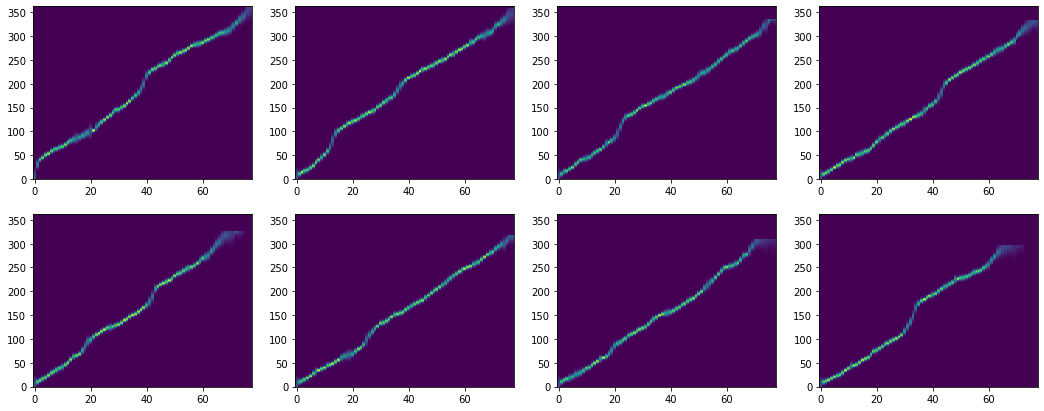

73601 0.08379197809279505 0.007328093517571688 0.306992769241333
73602 0.04833427640808282 0.006362573709338903 0.2513306140899658
73603 0.15617290728748423 0.006424046121537685 0.27515244483947754
73604 0.09433020643068483 0.005683119874447584 0.2723088264465332
73605 0.08431795137842071 0.008475935086607933 0.3957943916320801
73606 0.09903541317823246 0.008769810199737549 0.2633330821990967
73607 0.10776589491134429 0.00744584808126092 0.2901027202606201
73608 0.06687684726394787 0.009810288436710835 0.2930467128753662
73609 0.09216757739275935 0.005756172351539135 0.2952880859375
73610 0.05712718952200085 0.009324871934950352 0.29532575607299805
73611 0.06698545236846742 0.0058976346626877785 0.2784616947174072
73612 0.06496124524526191 0.006525300443172455 0.3157832622528076
73613 0.06379912424052062 0.0065764435566961765 0.3067207336425781
73614 0.12951274027176948 0.006619451567530632 0.26377201080322266
73615 0.06787935918640253 0.008481431752443314 0.2821078300476074
73616 0.08

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import librosa.display
import time
import ntpath

first = True

while(True):
    for i, batch in enumerate(train_loader):
        t0 = time.time()
        
        model.train()
        model.zero_grad()
        
        batch = model.parse_batch(batch)
        outputs = model(batch)
        loss = criterion(batch, outputs)
        
        loss.backward()
        
        grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)
        
        optimizer.step()
        
        t1 = time.time()
        print(step, grad_norm, loss.item(), t1 - t0)
        
        if step % 10 == 0:
            logger.log('training loss', loss.item(), step)
            
        if step % 100 == 0 or first:
            first = False
            display.clear_output()

            _alignments = outputs["alignments"].data.cpu().numpy()
            batch_size = _alignments.shape[0]
            plt.figure(figsize=[18, 7])
            for i in range(8):
                plt.subplot(2, 4, i+1)
                plt.imshow(_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = save_dir + '/' + 'save_' + str(step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
            
        step += 1


In [16]:
path = save_dir + '/' + 'save_' + str(step)
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, path)
print('saved', path)


saved save/asr-kss/save_71411


In [17]:
import ntpath
from tqdm import tqdm_notebook

for i, batch in tqdm_notebook(enumerate(train_loader)):
    audio_paths = batch["audio_paths"]
    batch = model.parse_batch(batch)
    outputs = model(batch)
    
    _alignments = outputs['alignments'].data.cpu().numpy()
    _text_padded = batch['text_padded'].data.cpu().numpy()
    _input_lengths = batch['input_lengths'].cpu().numpy()
    _output_lengths = batch['output_lengths'].cpu().numpy()
    
    for j in range(len(batch['text_padded'])):
        _filename = ntpath.basename(audio_paths[j])
        _alignment = _alignments[j, :_output_lengths[j], :_input_lengths[j]]
        _text = _text_padded[j, :_output_lengths[j]]
        _params = outputs['params'][j, :_output_lengths[j]].data.cpu().numpy()
        
        data = {'text': _text,
                'alignment': _alignment, 
                'params': _params}
        
        numpy_path = 'attention_kss/' + _filename
        np.savez(numpy_path, **data, allow_pickle=False)


/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
_params = outputs['params'][0].data.cpu().numpy()
print(_params.shape)

In [ ]:
length = int(np.round(np.sum(_params[:, 0])))
mu = 0
alignments = []
for delta_mu, stddev in _params:
    mu = mu + delta_mu
    
    lin = np.linspace(0, length-1, length)
    Z = np.sqrt(2 * np.pi * stddev ** 2)
    alpha = 1 / Z * np.exp(-0.5 * (lin - mu) ** 2 / (stddev ** 2))
    alignments.append(alpha)
    
alignments = np.stack(alignments)
print(alignments.shape)

plt.imshow(alignments.T, aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.show()

_alignments = outputs["alignments"].data.cpu().numpy()
batch_size = _alignments.shape[0]
plt.imshow(_alignments[0].T, aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.show()

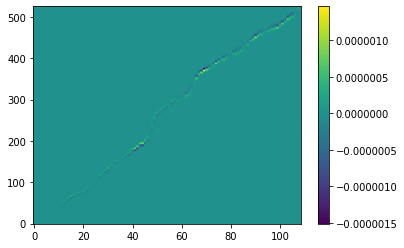

In [33]:
delta = alignments - _alignments[0]
plt.imshow(delta.T, aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.show()